# Análisis de sentimientos usando RNN

Hoy en día, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar el texto contenido en comentarios u opiniones (*review*) sobre una película para determinar su polaridad, es decir, determinar si reﬂeja un sentiemiento positivo o negativo. Usaremos el *Large Movie Review Dataset*, también conocido como *IMDB dataset* que contiene **50000 comentarios** de películas etiquetadas como buenas o malas (50%-50% train-testing).

------------------

## Librerias


In [8]:
import keras
import numpy as np

from keras.datasets import imdb
from keras.preprocessing import sequence
from matplotlib import pyplot as plt

----------------------

### Carga de Datos

Se utiliza la base de datos de imdb, la cual mediante la funcion *load_data* produce conjuntos separados por tuplas.


In [3]:
np.random.seed(3)
(X_train, y_train), (X_test, y_test) = imdb.load_data(path="B:\Programas\Google Drive\USM\Redes Neuronales\Tarea 3\datasets\imdb.npz",seed=15)

-------------
### Estudio de distribución


In [4]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Ahora que tenemos los datos cargados y listos para ser analizados, veremos su forma, la cantidad de clases que tiene, el número de palabras. De aquí esperamos que el contenido sea de *(50000, None)* dadas las especificaciones en la [Documentación de keras imdb](https://keras.io/datasets/), además estas podrán ser *"buenas"* o *"malas"* lo que nos indice a pensar que será un comportamiento binario el número de clases. 

Training data:
(50000,) 
(50000,)

Clases:
[0 1]

Review lenght: 


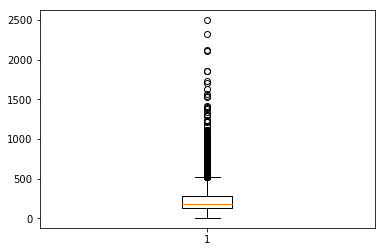

In [5]:
print "Training data:\n", X.shape, "\n", y.shape

print "\nClases:\n", np.unique(y)

print "\nReview lenght: "
result = map(len, X)
plt.boxplot(result)
plt.show()

Podemos notar la alta concentración en comentarios con menos de 500 palabras, teniendo una media de *234.75892* palabras y una desviación estandar de *172.91149*. (Ambos datos obtenidos a través de **np.mean** y **np.std**). Ahora bien para analizar las palabras aprovechares la indexación que viene en este dataset. Se muestran algunos gráficos que corresponden a los datos obtenidos mediante **np.unique(ds, return_counts=True)**. Tomando en cuenta que las cantidades de palabras en estos ejemplos son las siguiente:

In [7]:
print "\nCantidad de palabras distintas:", len(np.unique(np.hstack(X)))
print "\nCantidad de palabras totales:", len(np.hstack(X))


Cantidad de palabras distintas: 88585

Cantidad de palabras totales: 11737946


Nota: *Todos los gráficos a continuación fueron creados mediante el script **frecuencia.py** de los archivos de **scripts** *.

<img src="images/fig1.png" style="width: 500px;" name="Grafico 1"/>
<center>
Gráfico 1: AxisY Frecuencia vs AxisX Indice de palabra
</center>

Dentro de todo, no se puede establecer un mayor criterio dada la alta cantidad de datos, lo que si podemos notar es que se produce una especia de linea convergente hacia valores menores con los índices mayores mientras que los índices menores obtienen una frecuencia muy por sobre el resto.

<img src="images/zoom1.png" style="width: 500px;" name="Grafico 2"/>
<center>
Gráfico 1.1: Zoom del gráfico 1
</center>

Si miramos el mismo gráficos pero un poco más cercano a los valores de índice entre *1-1500*, se puede aprecia la curva mencionada que tiene una suerte de $ \frac{1}{x} $. Esto nos lleva a que se produzca una eventual **ley de Zipf**. [(Ver más)](https://es.wikipedia.org/wiki/Ley_de_Zipf) Esta ley menciona que la distribución del lenguaje puede aproximarse a

\begin{equation}
P_n  \to  \frac{1}{n^a}
\end{equation}

donde $P_n$ es la frecuencia de la n-ésima palabra más frecuente y $a$ es un número real positivo, en general ligeramente superior a 1. Un gráfico en representación logarítmica de la ley es el siguiente:

<img src="https://upload.wikimedia.org/wikipedia/commons/d/da/Zipf_30wiki_es_labels.png" style="width: 500px;" name="Grafico 3"/>
<center>
Imagen 1: Ley de Zipf
</center>

Como nuestra distribución presentaba estas caracteristicas quisimos gráficar nuestros datos de manera logarítmica obteniendo:

<img src="images/log1.png" style="width: 500px;" name="Grafico 4"/>
<center>
Gráfico 1.2: Representación logarítmica del gráfico 1
</center>

Sin lugar a dudas, el gráfico presenta características abrumadores, con un pick inicial y una alta densidad al final, pero dejando estos conceptos de lado y analizando la base del gráfico podemos notar que si se aprecia la curva esperable.

*Ahora bien, ¿cómo cambian estas características al separar los textos de acuerdo a sus clases?*

Lo que se esperaría en este análisis es que no debiese cambiar, debido a que la Ley de Zipf habla sobre una distribución del lenguaje más que de las palabras especificas que pueden conllevar un sentimiento por sobre otro. **Nota** nuevamente los gráficos fueron obtenidos a través del script *frecuencia.py*.

<img src="images/fig2.png" style="width: 500px;" name="Grafico 5"/>
<center>
Gráfico 2: Representación de los datos separados por clase
</center>

<img src="images/zoom4.png" style="width: 500px;" name="Grafico 6"/>
<center>
Gráfico 2.1: Zoom del gráfico 2
</center>

<img src="images/log2.png" style="width: 500px;" name="Grafico 7"/>
<center>
Gráfico 2.2: Representación logarítmica del gráfico 2
</center>

Tal como se esperaba, los resultados fueron prácticamente los mismos. La única conclusión feaciente que podemos realizar luego de hacer esta comparativa es que las palabras indexadas como 0, que equivalen a las palabras desconocidas, están relacionadas a comentarios negativos.

---------------------------

### Carga de datos acotada

Dado que la carga de datos se basa en un criterio de *most used words*, basta con cargar una cantidad de datos más acotada para que se cumpla el requerimiento.

In [13]:
(X_train2, y_train2), (X_test2, y_test2) = imdb.load_data(path="B:\Programas\Google Drive\USM\Redes Neuronales\Tarea 3\datasets\imdb.npz", num_words=3000, seed=15)

X_train2 = sequence.pad_sequences(X_train, maxlen=500)
X_test2 = sequence.pad_sequences(X_test, maxlen=500)

Dado que se están utilizando una cantidad de palabras más acotadas, y que los comentarios fueron truncados a un máximo de 500 palabras, existirán algunas que no tengan estas caracteristicas, y como mencionamos en un momentos las palabras con índice 0, son las irreconocibles, por lo tanto cuando tengamos un modelo entrenable este asumirá comentarios del mismo largo lo que facilitará el modelaje de la red a entrenar.